In [1]:
import os
import cv2
import numpy as np
import matplotlib.cm as cm
import json
import xmltodict
import pandas as pd
from scipy.stats import kurtosis, skew, mode
from statistics import mean, median
from typing import Tuple
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

In [2]:
FINAL_DATA = '/Users/ninz/thesis/data/final_data'
ANNOTATIONS = '/Users/ninz/thesis/data/final_data/annotations_updated.xml'
FIGURE_SIZE = 3
START_RANGE = 75
END_RANGE = 150
SEED = 42

In [3]:
def convert_xml(file_path: str) -> dict:
    """Convert to dict."""
    with open(file_path) as xml_file:
        data_dict = xmltodict.parse(xml_file.read())

    return json.loads(json.dumps(data_dict))


def convert_from_cvat(xtl: float, ytl: float, xbr: float, ybr: float) -> Tuple[int, int, int, int]:
    """
    Convert format from cvat.

    :param xtl:
    :param ytl:
    :param xbr:
    :param ybr:
    :return:
    """
    x = int(float(xtl))
    y = int(float(ytl))
    w = int(float(xbr)) - x
    h = int(float(ybr)) - y
    return x, y, w, h


def separate_label(data, label='damage'):
    return [x for x in data if x['@label'] == label]


def colored_hist(img, mask=None):
    color = ('b','g','r')
    ret = []
    for i, col in enumerate(color):
        histr = cv2.calcHist([img], [i], mask, [256], [0,256])
        flat = histr.flatten()
        kurt = kurtosis(flat)
        sk = skew(flat)
        ret.append([col, kurt, sk])
    
    return ret
        

def bw_hist(img, mask=None):
    hist_bw = cv2.calcHist([img], [0], None, [256], [0, 256])
    flat = hist_bw.flatten()
    kurt = kurtosis(flat)
    sk = skew(flat)
    return ['bw', kurt, sk]


def apply_median_filter(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image = cv2.medianBlur(image, FIGURE_SIZE)
    return cv2.cvtColor(image, cv2.COLOR_HSV2BGR)


def apply_median_filter_bw(image):
    return cv2.medianBlur(image, FIGURE_SIZE)


def extract_box_feature(box, original, label):
    color = ('b','g','r')
    x, y, w, h = convert_from_cvat(
        box["@xtl"], box["@ytl"],
        box["@xbr"], box["@ybr"]
    )

    box_feature = []
    
    cropped = original[y:y+h, x:x+w]
    bgr_filtered = apply_median_filter(cropped)
    cropped_bw = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    bw_filter = apply_median_filter_bw(cropped_bw)
    
    c = colored_hist(bgr_filtered)
    for col_value in c:
        # Add kurtosis and skewness
        #box_feature += col_value[1:]
        box_feature.append(col_value[1])
        box_feature.append(col_value[2])
        
    bw = bw_hist(bw_filter)
    box_feature.append(bw[1])
    box_feature.append(bw[2])
    # box_feature.append(bw[1:])
    box_feature.append(1 if label == 'damage' else 0)
    return box_feature


def extract_img_feature(file_path: str):
    original = cv2.imread(file_path)
#     original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    file_name = os.path.basename(file_path)
    feature_list = []
    
    meta = images[file_name]
    if type(meta["box"]) == dict:
        boxes = [meta["box"]]
    else:
        boxes = meta["box"]

    damage = separate_label(boxes, 'damage')
    no_damage = separate_label(boxes, 'no_damage')
    
    for i, item in enumerate(damage):
        box_hist = extract_box_feature(item, original,'damage')
        feature_list.append(box_hist)
        
    for i, item in enumerate(no_damage):
        box_hist = extract_box_feature(item, original,'no_damage')
        feature_list.append(box_hist)
        
    return feature_list


def get_features():
    all_features = []
    for img_name in img_files:
        if img_name not in exclude:        
            file_path = os.path.join(FINAL_DATA, img_name)
            feat = extract_img_feature(file_path)
            all_features += feat
    
    return all_features


# Extract all features
json_annotations = convert_xml(ANNOTATIONS)
images = {x["@name"]: x for x in json_annotations["annotations"]["image"]}

exclude = ['1_1.JPG']
img_files = images.keys()

In [6]:
def graph_scores(x, svc, mlp, title):
    fig = plt.figure()
    ax = plt.axes()

    ax.plot(x, svc, color='blue', marker='o', label='svc')
    ax.plot(x, mlp, color='green', marker='^', label='mlp')
    ax.legend()
    ax.grid(True)
    ax.set_xlabel('Figure size')
    ax.set_ylabel('Scores')
    ax.set_title(title, fontsize=10)
    plt.show()

def single_channel_graph(color, ax, kd, knd, sd, snd, title):
    ax.scatter(x=kd, y=sd, marker='^', label='damaged', alpha=0.4, edgecolors='none')
    ax.scatter(x=knd, y=snd, marker='o', label='no_damage', alpha=0.4, edgecolors='none')
    ax.legend()
    ax.grid(True)
    ax.set_xlabel('Kurtosis')
    ax.set_ylabel('Skewness')
    ax.set_title(title, fontsize=15, color=color)
    

def graph_data(data: list, title: str):
    b_kurt = {'damage': [], 'nodamage': []}
    b_skew = {'damage': [], 'nodamage': []}
    r_kurt = {'damage': [], 'nodamage': []}
    r_skew = {'damage': [], 'nodamage': []}
    g_kurt = {'damage': [], 'nodamage': []}
    g_skew = {'damage': [], 'nodamage': []}
    bw_kurt = {'damage': [], 'nodamage': []}
    bw_skew = {'damage': [], 'nodamage': []}
    
    for i, item in enumerate(data):
        if item[-1] == 1:
            _label = 'damage'
        else:
            _label = 'nodamage'
            
        b_kurt[_label].append(item[0])
        b_skew[_label].append(item[1])
        g_kurt[_label].append(item[0])
        g_skew[_label].append(item[1])
        r_kurt[_label].append(item[0])
        r_skew[_label].append(item[1])
        bw_kurt[_label].append(item[0])
        bw_skew[_label].append(item[1])

            
    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
#     fig.tight_layout() 
    fig.suptitle(title, fontsize=35)
    
    single_channel_graph('blue', ax[0, 0], b_kurt['damage'], b_kurt['nodamage'], b_skew['damage'], b_skew['nodamage'], 'Blue Channel')
    single_channel_graph('green', ax[0, 1], g_kurt['damage'], g_kurt['nodamage'], g_skew['damage'], g_skew['nodamage'], 'Green Channel')
    single_channel_graph('red', ax[1, 0], r_kurt['damage'], r_kurt['nodamage'], r_skew['damage'], r_skew['nodamage'], 'Red Channel')
    single_channel_graph('black', ax[1, 1], bw_kurt['damage'], bw_kurt['nodamage'], bw_skew['damage'], bw_skew['nodamage'], 'BW Channel')
    
    plt.show()            

# Run classifiers
def run_classifiers(X, y, fold=10, hidden_layers=(100, ), to_print=True):
    X = np.array(X)
    y = np.array(y)
    skf = StratifiedKFold(n_splits=fold, random_state=SEED, shuffle=True)
    skf.get_n_splits(X, y)
    i = 0
    svc_scores = []
    mlp_scores = []
    accuracy_svc = []
    accuracy_mlp = []
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        svc_accuracy = round(clf.score(X_test, y_test), 5)
        svc_f1 = round(f1_score(y_pred, y_test), 5)
        svc_scores.append(svc_f1)
        accuracy_svc.append(svc_accuracy)
        
        clf = make_pipeline(
            StandardScaler(),
            MLPClassifier(
                solver='lbfgs', 
                alpha=0.00001, 
                hidden_layer_sizes=hidden_layers, 
                max_iter=10000, random_state=SEED))

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        mlp_accuracy = round(clf.score(X_test, y_test), 5)
        mlp_f1 = round(f1_score(y_pred, y_test), 5)
        mlp_scores.append(mlp_f1)
        accuracy_mlp.append(mlp_accuracy)
        
        if to_print:
            print(f'**Fold {i}**')
            print(f'SVC Accuracy: {svc_accuracy} \tF1: {svc_f1}')
            print(f'MLP Accuracy: {mlp_accuracy} \tF1: {mlp_f1}')
        i += 1
    
    if to_print:
        print(f'F1 scores for {fold} fold.')
        print(f'SVC mean: {round(np.mean(svc_scores), 4)} std deviation:{round(np.std(svc_scores), 4)}')
        print(f'MLP mean: {round(np.mean(mlp_scores), 4)} std deviation:{round(np.std(mlp_scores), 4)}')
        print(f'Accuracy scores for {fold} fold.')
        print(f'SVC mean: {round(np.mean(accuracy_svc), 4)} std deviation:{round(np.std(accuracy_svc), 4)}')
        print(f'MLP mean: {round(np.mean(accuracy_mlp), 4)} std deviation:{round(np.std(accuracy_mlp), 4)}')
    return svc_scores, mlp_scores


## Effect of different median filter sizes

To understand the effect of median filter with different kernel size on the model performance, we compared SVC and MLP (NN) classifiers. The initial observation in our previous analysis suggest that there is no improvement of seperability as we increase the kernel size. 

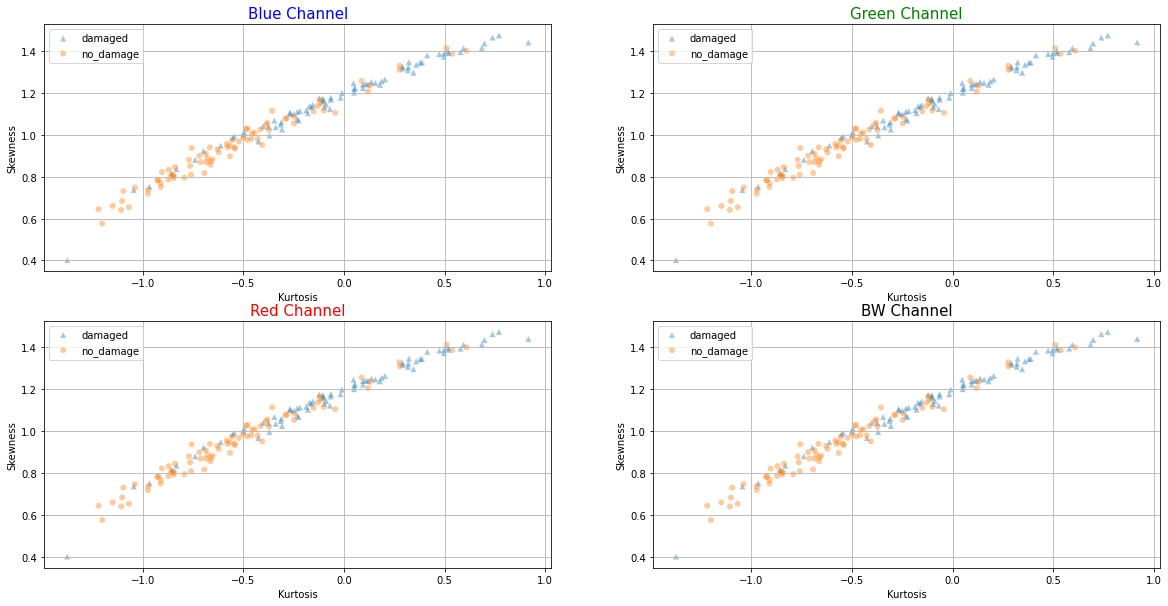

**Fold 0**
SVC Accuracy: 0.75 	F1: 0.75
MLP Accuracy: 0.75 	F1: 0.75
**Fold 1**
SVC Accuracy: 0.8125 	F1: 0.82353
MLP Accuracy: 0.6875 	F1: 0.70588
**Fold 2**
SVC Accuracy: 0.875 	F1: 0.875
MLP Accuracy: 0.75 	F1: 0.75
**Fold 3**
SVC Accuracy: 0.6875 	F1: 0.66667
MLP Accuracy: 0.6875 	F1: 0.70588
**Fold 4**
SVC Accuracy: 0.75 	F1: 0.75
MLP Accuracy: 0.875 	F1: 0.88889
**Fold 5**
SVC Accuracy: 0.9375 	F1: 0.94118
MLP Accuracy: 0.625 	F1: 0.625
**Fold 6**
SVC Accuracy: 0.8125 	F1: 0.76923
MLP Accuracy: 0.625 	F1: 0.5
**Fold 7**
SVC Accuracy: 0.5625 	F1: 0.58824
MLP Accuracy: 0.4375 	F1: 0.47059
**Fold 8**
SVC Accuracy: 0.86667 	F1: 0.875
MLP Accuracy: 0.86667 	F1: 0.875
**Fold 9**
SVC Accuracy: 0.86667 	F1: 0.83333
MLP Accuracy: 0.73333 	F1: 0.75
F1 scores for 10 fold.
SVC mean: 0.7872 std deviation:0.0999
MLP mean: 0.7021 std deviation:0.1312
Accuracy scores for 10 fold.
SVC mean: 0.7921 std deviation:0.1035
MLP mean: 0.7038 std deviation:0.1204





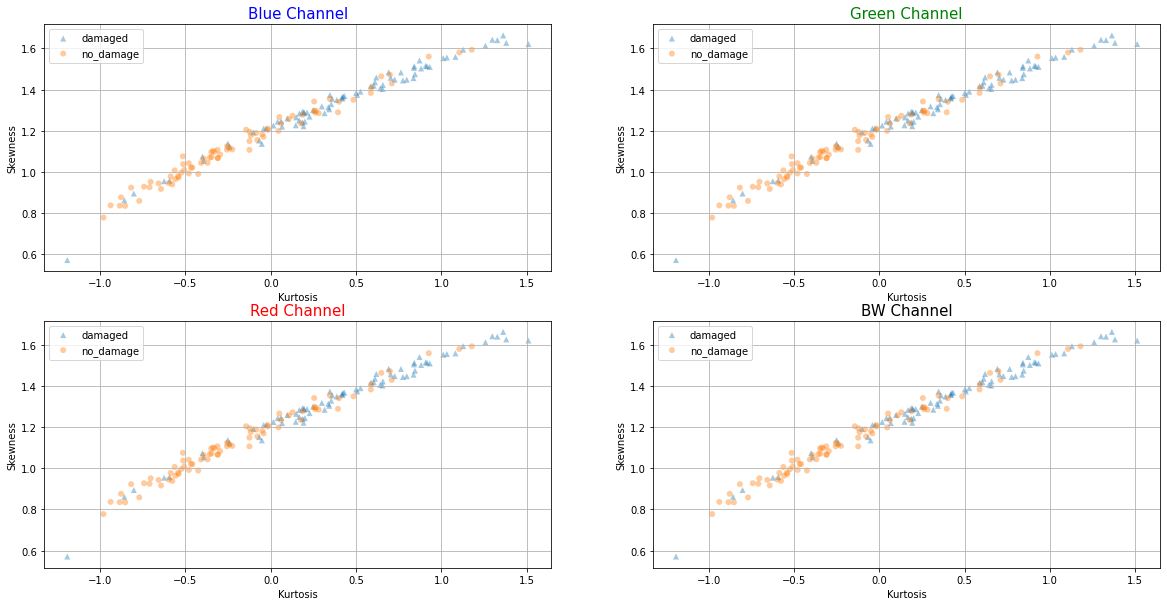

**Fold 0**
SVC Accuracy: 0.625 	F1: 0.66667
MLP Accuracy: 0.75 	F1: 0.71429
**Fold 1**
SVC Accuracy: 0.8125 	F1: 0.82353
MLP Accuracy: 0.625 	F1: 0.625
**Fold 2**
SVC Accuracy: 0.8125 	F1: 0.8
MLP Accuracy: 0.625 	F1: 0.57143
**Fold 3**
SVC Accuracy: 0.6875 	F1: 0.66667
MLP Accuracy: 0.75 	F1: 0.75
**Fold 4**
SVC Accuracy: 0.75 	F1: 0.75
MLP Accuracy: 0.6875 	F1: 0.70588
**Fold 5**
SVC Accuracy: 0.8125 	F1: 0.84211
MLP Accuracy: 0.5625 	F1: 0.58824
**Fold 6**
SVC Accuracy: 0.75 	F1: 0.66667
MLP Accuracy: 0.5625 	F1: 0.53333
**Fold 7**
SVC Accuracy: 0.5625 	F1: 0.58824
MLP Accuracy: 0.625 	F1: 0.625
**Fold 8**
SVC Accuracy: 0.8 	F1: 0.8
MLP Accuracy: 0.8 	F1: 0.8
**Fold 9**
SVC Accuracy: 0.8 	F1: 0.76923
MLP Accuracy: 0.8 	F1: 0.76923
F1 scores for 10 fold.
SVC mean: 0.7373 std deviation:0.0804
MLP mean: 0.6682 std deviation:0.0869
Accuracy scores for 10 fold.
SVC mean: 0.7412 std deviation:0.084
MLP mean: 0.6788 std deviation:0.0868





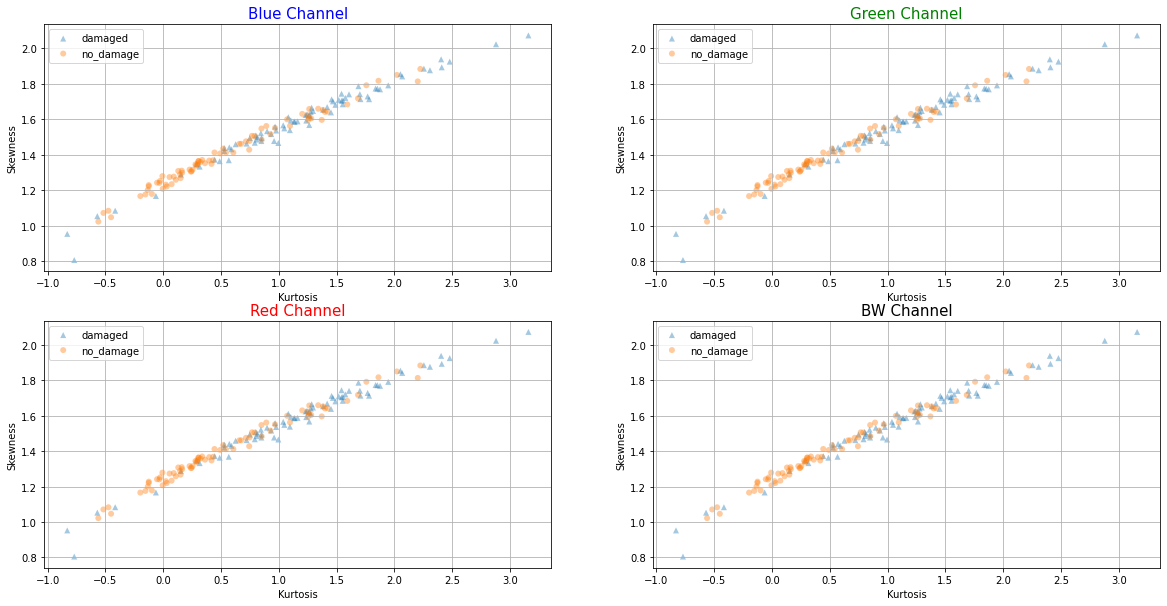

**Fold 0**
SVC Accuracy: 0.625 	F1: 0.66667
MLP Accuracy: 0.5625 	F1: 0.58824
**Fold 1**
SVC Accuracy: 0.75 	F1: 0.75
MLP Accuracy: 0.6875 	F1: 0.66667
**Fold 2**
SVC Accuracy: 0.875 	F1: 0.875
MLP Accuracy: 0.625 	F1: 0.625
**Fold 3**
SVC Accuracy: 0.8125 	F1: 0.82353
MLP Accuracy: 0.6875 	F1: 0.66667
**Fold 4**
SVC Accuracy: 0.625 	F1: 0.625
MLP Accuracy: 0.75 	F1: 0.75
**Fold 5**
SVC Accuracy: 0.75 	F1: 0.8
MLP Accuracy: 0.8125 	F1: 0.8
**Fold 6**
SVC Accuracy: 0.75 	F1: 0.71429
MLP Accuracy: 0.6875 	F1: 0.54545
**Fold 7**
SVC Accuracy: 0.5 	F1: 0.55556
MLP Accuracy: 0.375 	F1: 0.44444
**Fold 8**
SVC Accuracy: 0.8 	F1: 0.8
MLP Accuracy: 0.93333 	F1: 0.94118
**Fold 9**
SVC Accuracy: 0.73333 	F1: 0.75
MLP Accuracy: 0.73333 	F1: 0.71429
F1 scores for 10 fold.
SVC mean: 0.736 std deviation:0.0926
MLP mean: 0.6742 std deviation:0.1318
Accuracy scores for 10 fold.
SVC mean: 0.7221 std deviation:0.1041
MLP mean: 0.6854 std deviation:0.1411





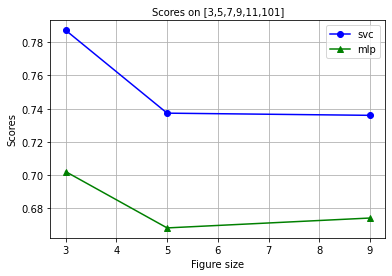

In [7]:
fig_sizes = [3, 5, 9]
svc_scores = []
mlp_scores = []

for f in fig_sizes:
    FIGURE_SIZE = f
    all_feat = get_features()
    X = [x[:8] for x in all_feat]
    y = [x[-1] for x in all_feat] 
    graph_data(all_feat, '')
    svc_score, mlp_score = run_classifiers(X, y)
    svc_scores.append(np.mean(svc_score))
    mlp_scores.append(np.mean(mlp_score))
    print('==================================================================================================')
    print('\n\n')
    
graph_scores(fig_sizes, svc_scores, mlp_scores, 'Scores on [3,5,7,9,11,101]')

### Observations

- SVC Classifier performes worse when we increase the median filter size
- MLP Classifier seems to always get a 100% F1 score 

> NOTE: When the filter size is 101x101, the MLP Classifier still performs at 100%??? WHY???

## Checking the effect of NN nodes on model performance

Filter size doesn't seem to affect the performance of the MLP Classifier. Check if changing the model parameter does something.

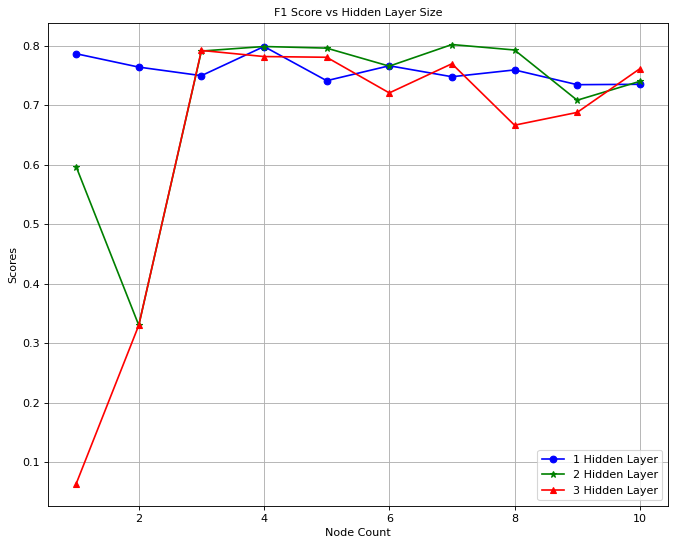

In [42]:
one_hidden_layer = [(1, ), (2, ), (3, ), (4, ), (5, ), (6, ), (7, ), (8, ), (9, ), (10, )]
two_hidden_layer = [(1, 1,), (2, 2,), (3, 3,), (4, 4,), (5, 5,), (6, 6,), (7, 7,), (8, 8,), (9, 9,), (10, 10,)]
three_hidden_layer = [(1, 1, 1,), (2, 2, 2,), (3, 3, 3,), (4, 4, 4,), (5, 5, 5,), (6, 6, 6,), (7, 7, 7,), (8, 8, 8,), (9, 9, 9,), (10, 10, 10,)]
colors = []

mlp_scores = []
mlp_scores2 = []
mlp_scores3 = []

all_feat = get_features()
X = [x[:8] for x in all_feat]
y = [x[-1] for x in all_feat] 
FIGURE_SIZE = 3

for hsize in one_hidden_layer:    
    _, mlp_score = run_classifiers(X, y, hidden_layers=hsize, to_print=False)
    mlp_scores.append(np.mean(mlp_score))

for hsize in two_hidden_layer:    
    _, mlp_score = run_classifiers(X, y, hidden_layers=hsize, to_print=False)
    mlp_scores2.append(np.mean(mlp_score))
    
for hsize in three_hidden_layer:    
    _, mlp_score = run_classifiers(X, y, hidden_layers=hsize, to_print=False)
    mlp_scores3.append(np.mean(mlp_score))
    
fig = plt.figure(figsize=(10, 8), dpi=80)
ax = plt.axes()
ax.plot(one_hidden_layer, mlp_scores, color='blue', marker='o', label='1 Hidden Layer')
ax.plot(one_hidden_layer, mlp_scores2, color='green', marker='*', label='2 Hidden Layer')
ax.plot(one_hidden_layer, mlp_scores3, color='red', marker='^', label='3 Hidden Layer')

ax.legend()
ax.grid(True)
ax.set_xlabel('Node Count')
ax.set_ylabel('Scores')
ax.set_title('F1 Score vs Hidden Layer Size', fontsize=10)
plt.show()

In [45]:
print(f"One hidden layer, 4 nodes: {mlp_scores[3]}")
print(f"Two hidden layer, (4, 4,) nodes: {mlp_scores2[3]}")
print(f"Two hidden layer, (7, 7,) nodes: {mlp_scores2[6]}")

One hidden layer, 4 nodes: 0.799065
Two hidden layer, (4, 4,) nodes: 0.799052
Two hidden layer, (7, 7,) nodes: 0.802365


#### Observatoins

- Two hidden layers seem to have the best score
- The scores decreases as we increase the number of nodes in each hidden layer

We can use `(4)` and `(7, 7,)` as hidden layer size

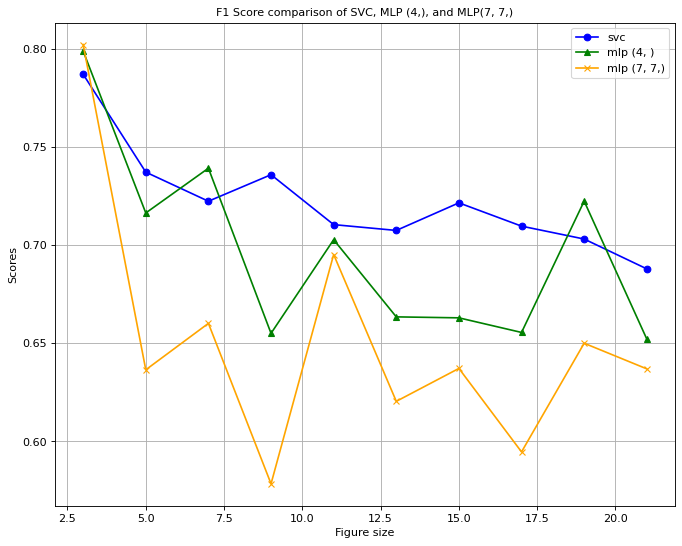

In [40]:
fig_sizes = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

svc_scores = []
mlp_scores = []
mlp_scores2 = []

for f in fig_sizes:
    FIGURE_SIZE = f
    all_feat = get_features()
    X = [x[:8] for x in all_feat]
    y = [x[-1] for x in all_feat] 
    svc_score, mlp_score = run_classifiers(X, y, hidden_layers=(4, ), to_print=False)
    svc_scores.append(np.mean(svc_score))
    mlp_scores.append(np.mean(mlp_score))

for f in fig_sizes:
    FIGURE_SIZE = f
    all_feat = get_features()
    X = [x[:8] for x in all_feat]
    y = [x[-1] for x in all_feat] 
    _, mlp_score = run_classifiers(X, y, hidden_layers=(7, 7), to_print=False)
    mlp_scores2.append(np.mean(mlp_score))

    
fig = plt.figure(figsize=(10, 8), dpi=80)
ax = plt.axes()

ax.plot(fig_sizes, svc_scores, color='blue', marker='o', label='svc')
ax.plot(fig_sizes, mlp_scores, color='green', marker='^', label='mlp (4, )')
ax.plot(fig_sizes, mlp_scores2, color='orange', marker='x', label='mlp (7, 7,)')
ax.legend()
ax.grid(True)
ax.set_xlabel('Figure size')
ax.set_ylabel('Scores')
ax.set_title('F1 Score comparison of SVC, MLP (4,), and MLP(7, 7,)', fontsize=10)
plt.show()

> The trend shows that bigger median filter decreases score

Fold scores for SVC, MLP(4,) and (7,7) using a 3x3 median Filter


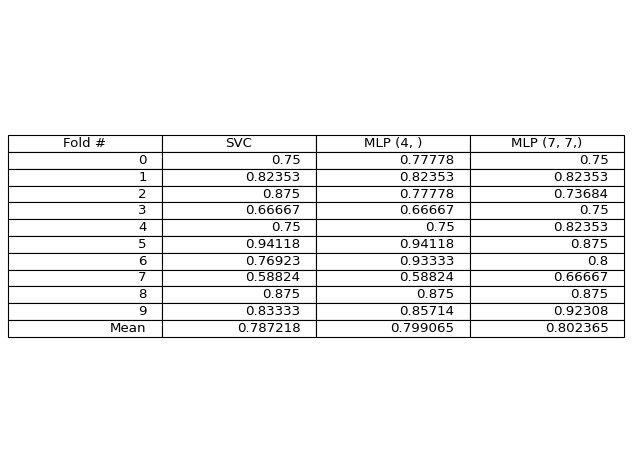

In [47]:
FIGURE_SIZE = 3
all_feat = get_features()
X = [x[:8] for x in all_feat]

y = [x[-1] for x in all_feat] 

_, mlp_score2 = run_classifiers(X, y, hidden_layers=(7, 7, ), to_print=False)
svc_score, mlp_score = run_classifiers(X, y, hidden_layers=(4, ), to_print=False)
print("Fold scores for SVC, MLP(4,) and (7,7) using a 3x3 median Filter")
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes()

vals = []
for i in range(10):
    vals.append([i, svc_score[i], mlp_score[i], mlp_score2[i]])
    
vals.append(['Mean', np.mean(svc_score), np.mean(mlp_score), np.mean(mlp_score2)])

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
tab = ax.table(cellText=vals, colLabels=['Fold #', 'SVC', 'MLP (4, )', 'MLP (7, 7,)'], loc='center')
tab.set_fontsize(12)
fig.tight_layout()
plt.show()
